# Combining snowfall detection procedure and snow compaction/temperature models

This notebook uses and combines the preliminary work done previously to see if models and procedures developed so far are consistent with observations.

We detect snow accumulation and erosion events, build layers accordingly, simulate their evolution and plot our results against the snow-depth curve obtained from the lidar.

### Imports

In [2]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy import f2py
import pandas as pd

In [3]:
# Fortran codes imports

import ddensity
import snowtemp

### Functions definition

In [4]:
def median_spacetime_filtering(ds, min_periods_val, time_window=11, x_span=11, y_span=11):
    '''
    Function to apply median filtering in time and space
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    # TODO take out time median
    # ds['snow_surface'] = ds['mean'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    # print(f'---> Median filtering in time with a window of {time_window}')
    ds['snow_surface'] = ds['mean'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


In [5]:
def new_median_spacetime_filtering(ds, min_periods_val, time_window=11, x_span=11, y_span=11):
    '''
    Function to apply median filtering in time and space for datasets containing 'surface' variable
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    # TODO take out time median
    # ds['snow_surface'] = ds['mean'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    # print(f'---> Median filtering in time with a window of {time_window}')
    ds['snow_surface'] = ds['surface'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


In [6]:

def get_snow_events(ds, x_sel, y_sel, time_window_std, time_window_mean, time_window_mean_diff, mean_diff_offset):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the sign of the difference between
    a rolling mean centerd left and a rolling mean centered right
    Args:
        ds: clean dataset with 'snow_surface' variable
        x_sel: x coordinate of the point of interest (index)
        y_sel: y coordinate of the point of interest (index)
        time_window_std: size of the rolling window to compute standard deviation
        time_window_mean: size of the rolling window to compute each mean (left and right)
        time_window_mean_diff: size of the rolling window to compute the difference between the two rolling means
        mean_diff_offset: index offset to take into account the lag due to rolling window size
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    mean_right_minus_mean_left = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=True).mean(dim='time') - ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=False).mean(dim='time')
    mean_right_minus_mean_left = mean_right_minus_mean_left.rolling(time=time_window_mean_diff, center=True).mean(dim='time').values

    snow_events_occurrences = stdev > 0.02   # booleans           # TODO make this modular
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        if mean_right_minus_mean_left[start_time_indices[index] + mean_diff_offset] >= 0:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


In [7]:
def get_change_in_snow_depth(ds, start_events, end_events, index_of_event, x_sel, y_sel):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
        ds: dataset containing the snow-depth data ('snow_surface' variable)
        start_events: list of time indices at which the events of interest (accumulation or erosion) started
        end_events: list of time indices at which the events of interest (accumulation or erosion) ended
        index_of_event: index of event of interest in the lists of time indices
        x_sel: index of the x-coordinate of the point of interest
        y_sel: index of the y-coordinate of the point of interest
    Returns:
        difference in snow-depth between the start and end of the event
    '''
    
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
    end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

### Define data

In [8]:
# Get data from files

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')

# all_data = xr.open_mfdataset('/home/mabonnet/Desktop/data/2021_2022_livox_surfaces/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# all_data.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_2021-2022.nc')
all_data_set = xr.open_dataset('data_2021-2022.nc')

In [9]:
# Define which dataset to use in what follows

data_set_used = all_data_set

In [10]:
# Pre-processing to get clean data

data_set_used = data_set_used.ffill(dim='time')
# median_spacetime_filtering(data_set_used, 11)
new_median_spacetime_filtering(data_set_used, 11)
data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() 


---> Median filtering in space with a window [11, 11]


### Define parameters

In [11]:
# Defining parameters for snow events detection

x_sel = 11
y_sel = 11
time_window_std = 25
time_window_mean = 19
time_window_mean_diff = 51
mean_diff_offset = 20


In [12]:
# Initial state for compaction/temperature model, with 1 layers

max_nb_of_layers = 20

ro_layer = np.zeros((max_nb_of_layers, 1))
ro_layer[0] = 150
tf = 0
dt = 100
ro_water = 1000
ro_ice = 910
t_old = np.zeros((max_nb_of_layers, 1))
t_old[0] = -5
jj = 1
dy_snow = np.zeros((max_nb_of_layers, 1))
dy_snow[0] = 0.2
a1 = 0.0013
a2 = 0.021
gamma = np.zeros((max_nb_of_layers, 1))
gamma[0] = 0
tsfc = -15
cp_snow = 2.1
melt_flag = np.zeros((max_nb_of_layers, 1))
melt_flag[0] = 0


In [13]:
# Initialize arrays to keep track of variables in time

ro_layer_evolution = [ro_layer]
depth_evolution = [dy_snow]
temperature_evolution = [t_old]

### Get snow events timing

In [15]:

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, time_window_mean, time_window_mean_diff, mean_diff_offset)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]


/tmp/ipykernel_17068/786278707.py:23: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
/tmp/ipykernel_17068/786278707.py:25: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  mean_right_minus_mean_left = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=True).mean(dim='time') - ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=False).mean(dim='time')
/tmp/ipykernel_17068/786278707.py:26: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  mean_right_minus_mean_left = mean_right_minus_mean_left.rolling(time=time_window_mean_di

In [18]:
# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - 1638796500000000000)/1000000000
# 1638796500000000000 is the first time point in data_dec_jan_feb > TODO make modular
# TODO units ???

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - 1638796500000000000)/1000000000

# print(end_accumulation_times, end_erosion_times)

### Simulate evolution of snowpack

In [19]:
# Update variables at each timepoint

# Define indices of first accumulation/erosion events coming up (updated when their time is past)
accumulation_index = 0
erosion_index = 0

for i in range(70000):
    if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
        # TODO put all this in a function
        ddepth = get_change_in_snow_depth(data_set_used, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
        ro_layer[jj] = 150
        t_old[jj] = -5
        dy_snow[jj] = ddepth  # ??? TODO
        gamma[jj] = 0
        melt_flag[jj] = 0
        jj += 1
        accumulation_index += 1
    
    if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
        # TODO put all this in a function
        ddepth = get_change_in_snow_depth(data_set_used, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
        if dy_snow[jj-1] > ddepth:
            dy_snow[jj-1] = dy_snow[jj-1] - ddepth
        else:
            jj -= 1
            dy_snow[jj] = 0  # ??? TODO
            ro_layer[jj] = 0  # ??? TODO
            t_old[jj] = 0
            gamma[jj] = 0
            melt_flag[jj] = 0
        erosion_index += 1
    
    # Update layers' parameters
    ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
    t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    
    # Keep track of events
    ro_layer_evolution.append(ro_layer)
    depth_evolution.append(dy_snow)
    temperature_evolution.append(t_old)

### Plot evolution of snowpack, compare with lidar measurements

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'Density')

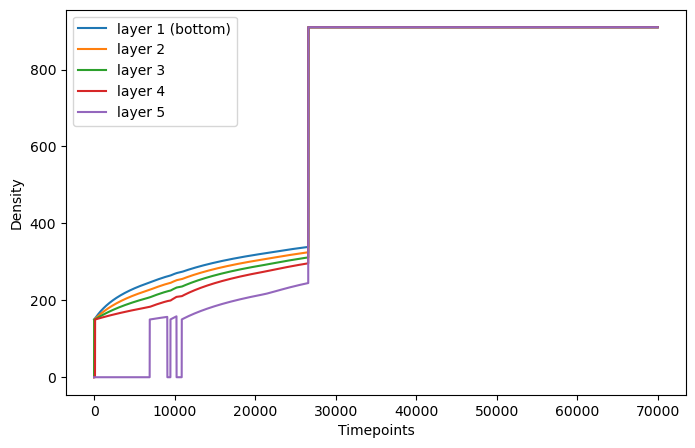

In [20]:
# Density

layer1 = [ro_layer_evolution[i][0] for i in range(len(ro_layer_evolution))]
layer2 = [ro_layer_evolution[i][1] for i in range(len(ro_layer_evolution))]
layer3 = [ro_layer_evolution[i][2] for i in range(len(ro_layer_evolution))]
layer4 = [ro_layer_evolution[i][3] for i in range(len(ro_layer_evolution))]
layer5 = [ro_layer_evolution[i][4] for i in range(len(ro_layer_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Density')

Text(0, 0.5, 'Depth')

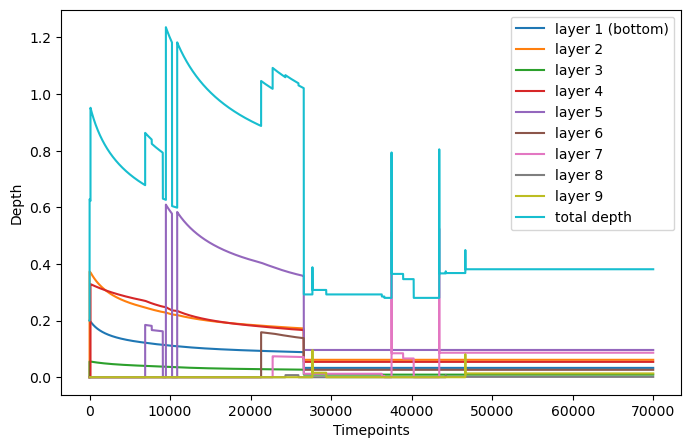

In [21]:
# Depth

layer1 = [depth_evolution[i][0] for i in range(len(depth_evolution))]
layer2 = [depth_evolution[i][1] for i in range(len(depth_evolution))]
layer3 = [depth_evolution[i][2] for i in range(len(depth_evolution))]
layer4 = [depth_evolution[i][3] for i in range(len(depth_evolution))]
layer5 = [depth_evolution[i][4] for i in range(len(depth_evolution))]
layer6 = [depth_evolution[i][5] for i in range(len(depth_evolution))]
layer7 = [depth_evolution[i][6] for i in range(len(depth_evolution))]
layer8 = [depth_evolution[i][7] for i in range(len(depth_evolution))]
layer9 = [depth_evolution[i][8] for i in range(len(depth_evolution))]
sum_layers = [layer1[i] + layer2[i] + layer3[i] + layer4[i] + layer5[i] + layer6[i] + layer7[i] + layer8[i] + layer9[i] for i in range(len(depth_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.plot(layer6, label='layer 6')
plt.plot(layer7, label='layer 7')
plt.plot(layer8, label='layer 8')
plt.plot(layer9, label='layer 9')
plt.plot(sum_layers, label='total depth')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Depth')

Text(0, 0.5, 'Depth')

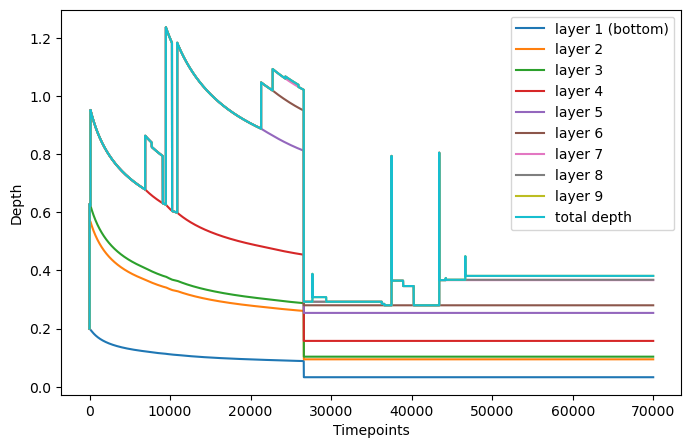

In [22]:
# Depth

layer1 = [depth_evolution[i][0] for i in range(len(depth_evolution))]
layer2 = [layer1[i] + depth_evolution[i][1] for i in range(len(depth_evolution))]
layer3 = [layer2[i] + depth_evolution[i][2] for i in range(len(depth_evolution))]
layer4 = [layer3[i] + depth_evolution[i][3] for i in range(len(depth_evolution))]
layer5 = [layer4[i] + depth_evolution[i][4] for i in range(len(depth_evolution))]
layer6 = [layer5[i] + depth_evolution[i][5] for i in range(len(depth_evolution))]
layer7 = [layer6[i] + depth_evolution[i][6] for i in range(len(depth_evolution))]
layer8 = [layer7[i] + depth_evolution[i][7] for i in range(len(depth_evolution))]
layer9 = [layer8[i] + depth_evolution[i][8] for i in range(len(depth_evolution))]
# sum_layers = [layer1[i] + layer2[i] + layer3[i] + layer4[i] + layer5[i] + layer6[i] + layer7[i] + layer8[i] + layer9[i] for i in range(len(depth_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.plot(layer6, label='layer 6')
plt.plot(layer7, label='layer 7')
plt.plot(layer8, label='layer 8')
plt.plot(layer9, label='layer 9')
plt.plot(sum_layers, label='total depth')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Depth')

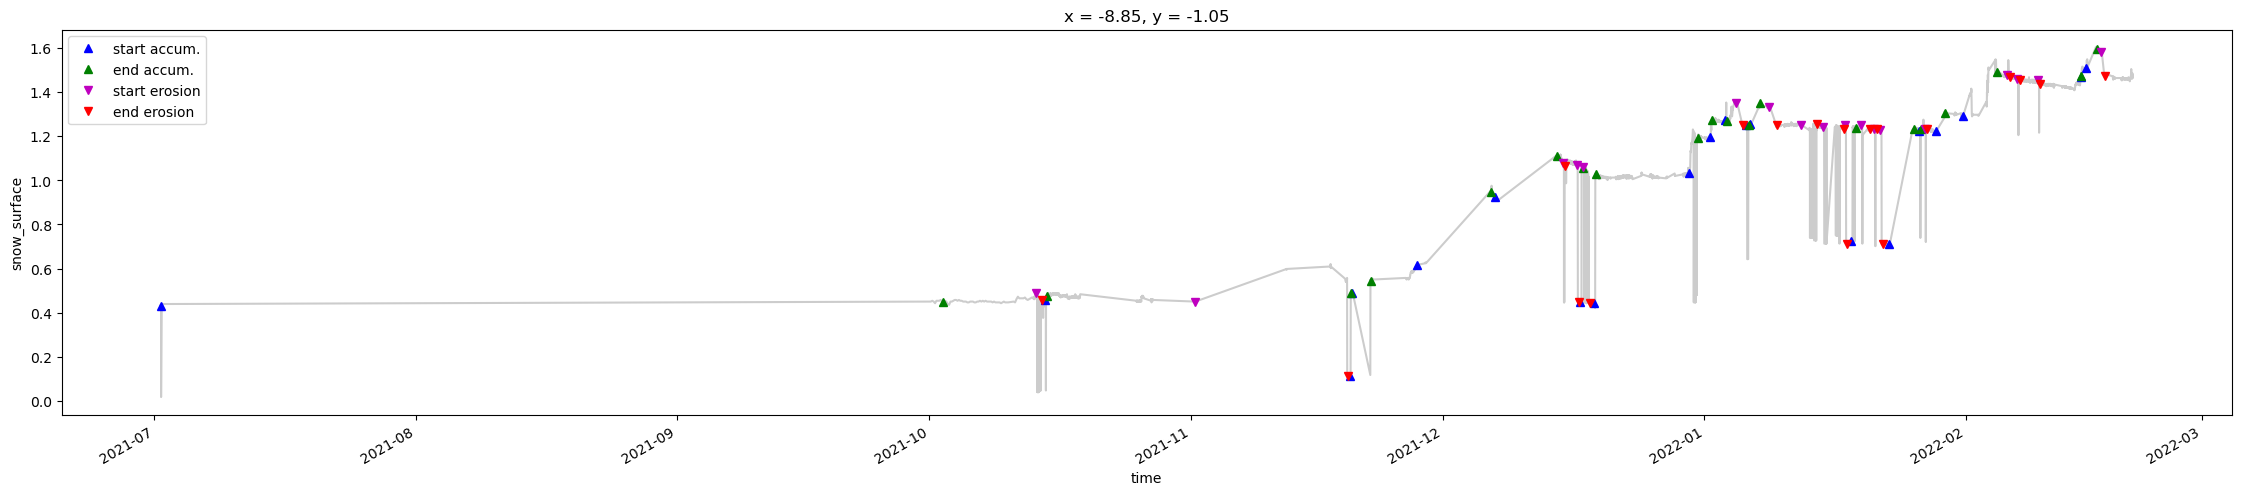

In [25]:
plt.figure(figsize=(28, 5))

data_set_used.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)

data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')

simulated_times = [(i*dt + 1638796500000000000) * 1000000000]
# plt.plot(simulated_times, sum_layers, label='simulated snow depth')   # TODO

plt.legend()


/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Comparison between lidar-measured and simulated snow depth')

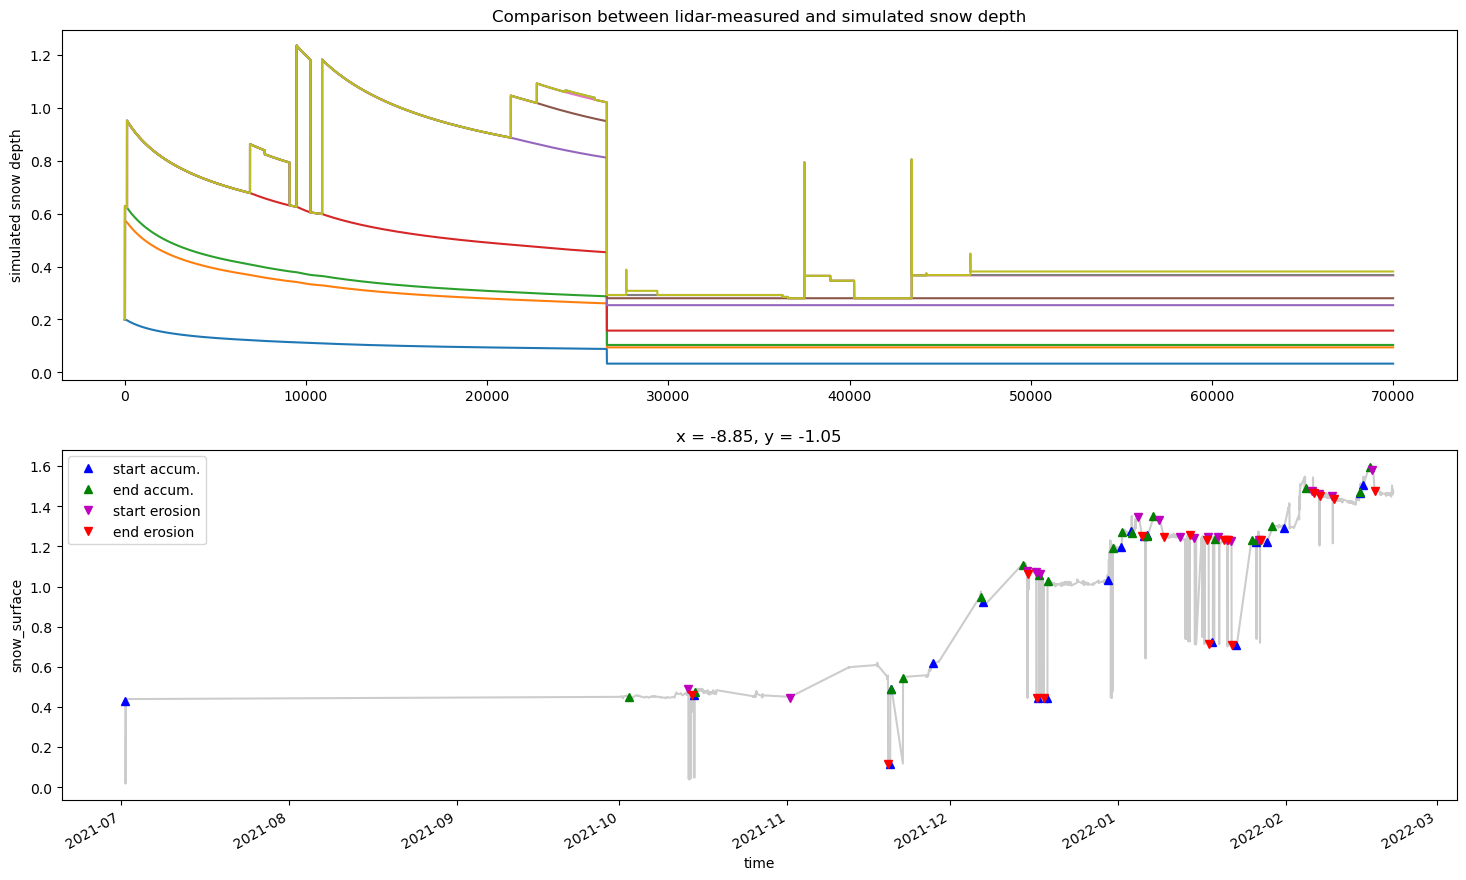

In [26]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(18, 10))

ax[0].plot(layer1, label='layer 1')
ax[0].plot(layer2, label='layer 2')
ax[0].plot(layer3, label='layer 3')
ax[0].plot(layer4, label='layer 4')
ax[0].plot(layer5, label='layer 5')
ax[0].plot(layer6, label='layer 6')
ax[0].plot(layer7, label='layer 7')
ax[0].plot(layer8, label='layer 8')
ax[0].plot(sum_layers, label='total depth')

ax[0].set_ylabel('simulated snow depth')

data_set_used.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2, ax=ax[1])

data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion', ax=ax[1])
ax[1].legend()

ax[0].set_title('Comparison between lidar-measured and simulated snow depth')

# fig.savefig('measured_vs_simul_snow_depth.png')

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'Temperature')

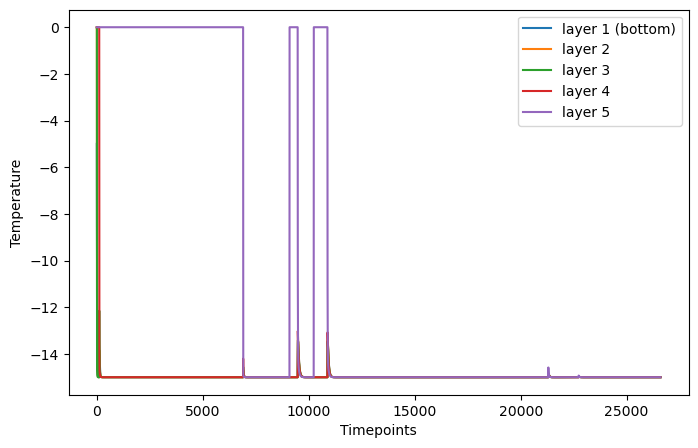

In [27]:
# Temperature

layer1 = [temperature_evolution[i][0] for i in range(len(temperature_evolution))]
layer2 = [temperature_evolution[i][1] for i in range(len(temperature_evolution))]
layer3 = [temperature_evolution[i][2] for i in range(len(temperature_evolution))]
layer4 = [temperature_evolution[i][3] for i in range(len(temperature_evolution))]
layer5 = [temperature_evolution[i][4] for i in range(len(temperature_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Temperature')

In [219]:
# TODO pas de temps sont trop grands pour temperature ?